# Signed Directed Bitcoin OTC web of trust network

### Dataset information:
This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.

<img src="data/image.png" alt="Drawing" style="width: 350px;"/>

Each line has one rating, sorted by time with the following format: 
    `SOURCE, TARGET, RATING, TIME`

Some draws of the network from GEPHI:
<img src="output/gephi_draws/screenshot_121233.png" alt="Drawing" style="width: 650px;"/>
<img src="output/gephi_draws/screenshot_121958.png" alt="Drawing" style="width: 650px;"/>

### Read data and build network using NetworkX

In [90]:
# imports
import collections

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import powerlaw

from data_tools import plot_functions as func

%matplotlib notebook

In [91]:
# read file
register_matplotlib_converters()
data = pd.read_csv('data/soc-sign-bitcoinotc.csv', sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)
# time is in epochtime format, can be transformed to date time
data.head()

,Source,Target,Rating,Time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [92]:
# create the graph
graph = nx.from_pandas_edgelist(data, source='Source', target='Target', edge_attr='Rating', create_using=nx.DiGraph)
n_nodes = graph.number_of_nodes()
n_edges = graph.number_of_edges()

# Network properties

Contents:
* 1 - Number of nodes and edges


* 2 - Edge weights (ratings) frequency and distribution 


* 3 - Degree centrality:
     * 3.1 Degree centrality (considering graph as undirected)
     * 3.2 In-Degree centrality
     * 3.3 Out-Degree centrality
     
     
* 4 - Weighted degree centrality:
     * 4.1 Weighted degree centrality (considering graph as undirected)
     * 4.2 Weighted In-Degree centrality
     * 4.3 Weighted Out-Degree centrality
     
     
* 5 - Average node rating
     * 5.1 In & out average rating distributions
     * 5.2 Absolute difference between in & out average ratings distribution
     * 5.3 In & out average ratings 2d plane projection
     
     
* 6 - Stats summary

In [93]:
# Table to store stats for each node.
stats = pd.DataFrame(graph.nodes()) 
stats.columns = ['Node']
#stats.head()

## 1) Number of nodes and edges

In [94]:
print("Number of nodes:", n_nodes)
print("Number of edges:", n_edges)

Number of nodes: 5881
Number of edges: 35592


## 2) Edge weights (ratings) frequency and distribution

In [95]:
counts = data.groupby(['Rating']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts

,Rating,Frequency,Probability
0,-10,2413,0.067796
1,-9,20,0.000562
2,-8,31,0.000871
3,-7,14,0.000393
4,-6,5,0.000140
5,-5,179,0.005029
6,-4,27,0.000759
7,-3,91,0.002557
8,-2,182,0.005114
9,-1,601,0.016886


<IPython.core.display.Javascript object>


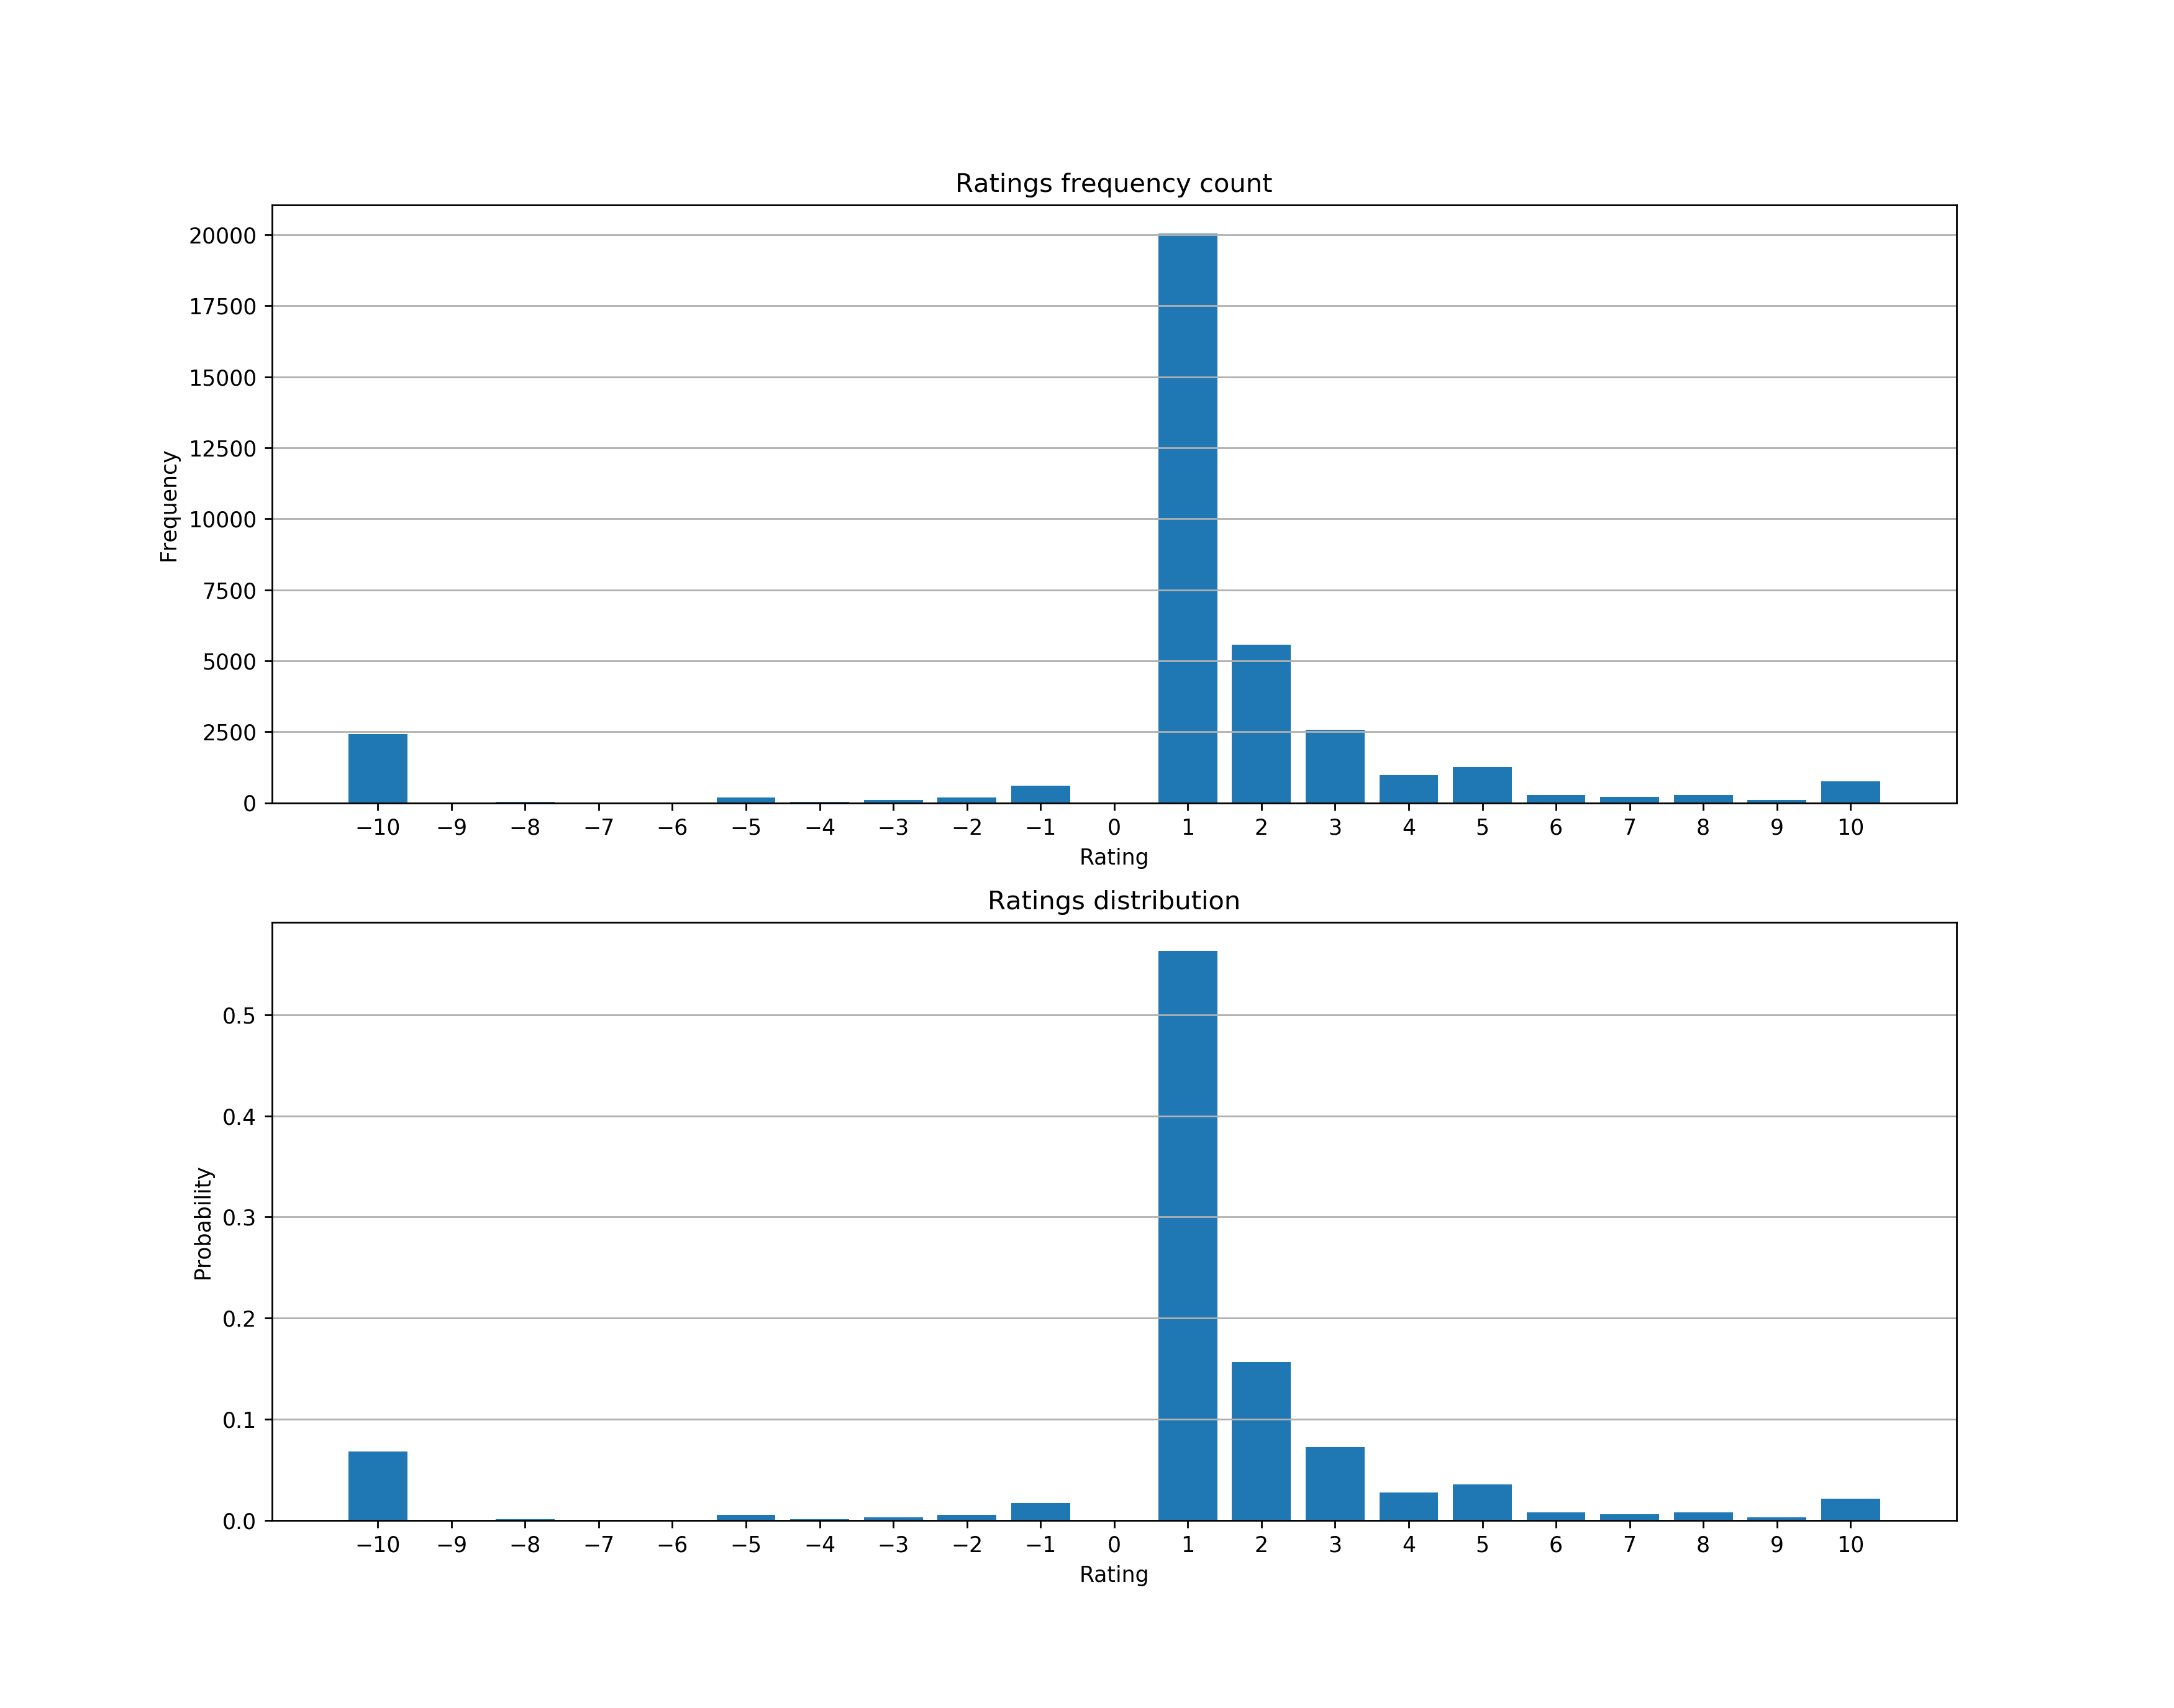

In [96]:
fig = plt.figure()
fig.set_size_inches(14.0, 11.0)

bins = np.linspace(-10,10,21)

# Ratings frequency (count for each rating).
ax = plt.subplot(2, 1, 1)

plt.bar(counts['Rating'], counts['Frequency'])

plt.title('Ratings frequency count')
plt.xlabel('Rating')
plt.ylabel('Frequency')

ax.xaxis.set_ticks(bins)

plt.grid(True, axis='y')

# Ratings probability (distribution).
ax = plt.subplot(2, 1, 2)

plt.bar(counts['Rating'], counts['Probability'])

plt.title('Ratings distribution')
plt.xlabel('Rating')
plt.ylabel('Probability')

ax.xaxis.set_ticks(bins)

plt.grid(True, axis='y')

#fig.savefig("output/ratings_frequency.pdf")

plt.show()

## 3) Degree centrality

### 3.1) Degree centrality (considering graph as undirected)

In [97]:
# convert dictionary into list of tuples
degree_list = [v for k, v in nx.degree_centrality(graph).items()] 
in_degree_list = [v for k, v in nx.in_degree_centrality(graph).items()] 
out_degree_list = [v for k, v in nx.out_degree_centrality(graph).items()] 

# Store node degree centrality (considering graph as unirected)
stats['Degree'] = degree_list

# Store node in-degree centrality (considering graph as directed)
stats['InDegree'] = in_degree_list

# Store node out-degree centrality (considering graph as directed)
stats['OutDegree'] = out_degree_list

# Transform normalized (%) to absolute value.
stats['Degree'] = round(stats['Degree'] * (n_nodes-1))
stats['InDegree'] = round(stats['InDegree']  * (n_nodes-1))                
stats['OutDegree'] = round(stats['OutDegree'] * (n_nodes-1))

#### Top 10 nodes with highest degree Centrality

In [98]:
stats.sort_values(by='Degree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree
23,35,1298.0,535.0,763.0
2571,2642,818.0,412.0,406.0
1785,1810,715.0,311.0,404.0
2071,2125,577.0,180.0,397.0
1980,2028,572.0,279.0,293.0
945,905,528.0,264.0,264.0
4071,4172,486.0,222.0,264.0
10,7,448.0,216.0,232.0
3,1,441.0,226.0,215.0
4089,4197,405.0,203.0,202.0


#### Degree distribution

In [99]:
counts = stats.groupby(['Degree']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts.head(10)

,Degree,Frequency,Probability
0,1.0,829,0.140962
1,2.0,1622,0.275803
2,3.0,380,0.064615
3,4.0,621,0.105594
4,5.0,259,0.044040
5,6.0,324,0.055093
6,7.0,153,0.026016
7,8.0,185,0.031457
8,9.0,112,0.019044
9,10.0,139,0.023635


<IPython.core.display.Javascript object>


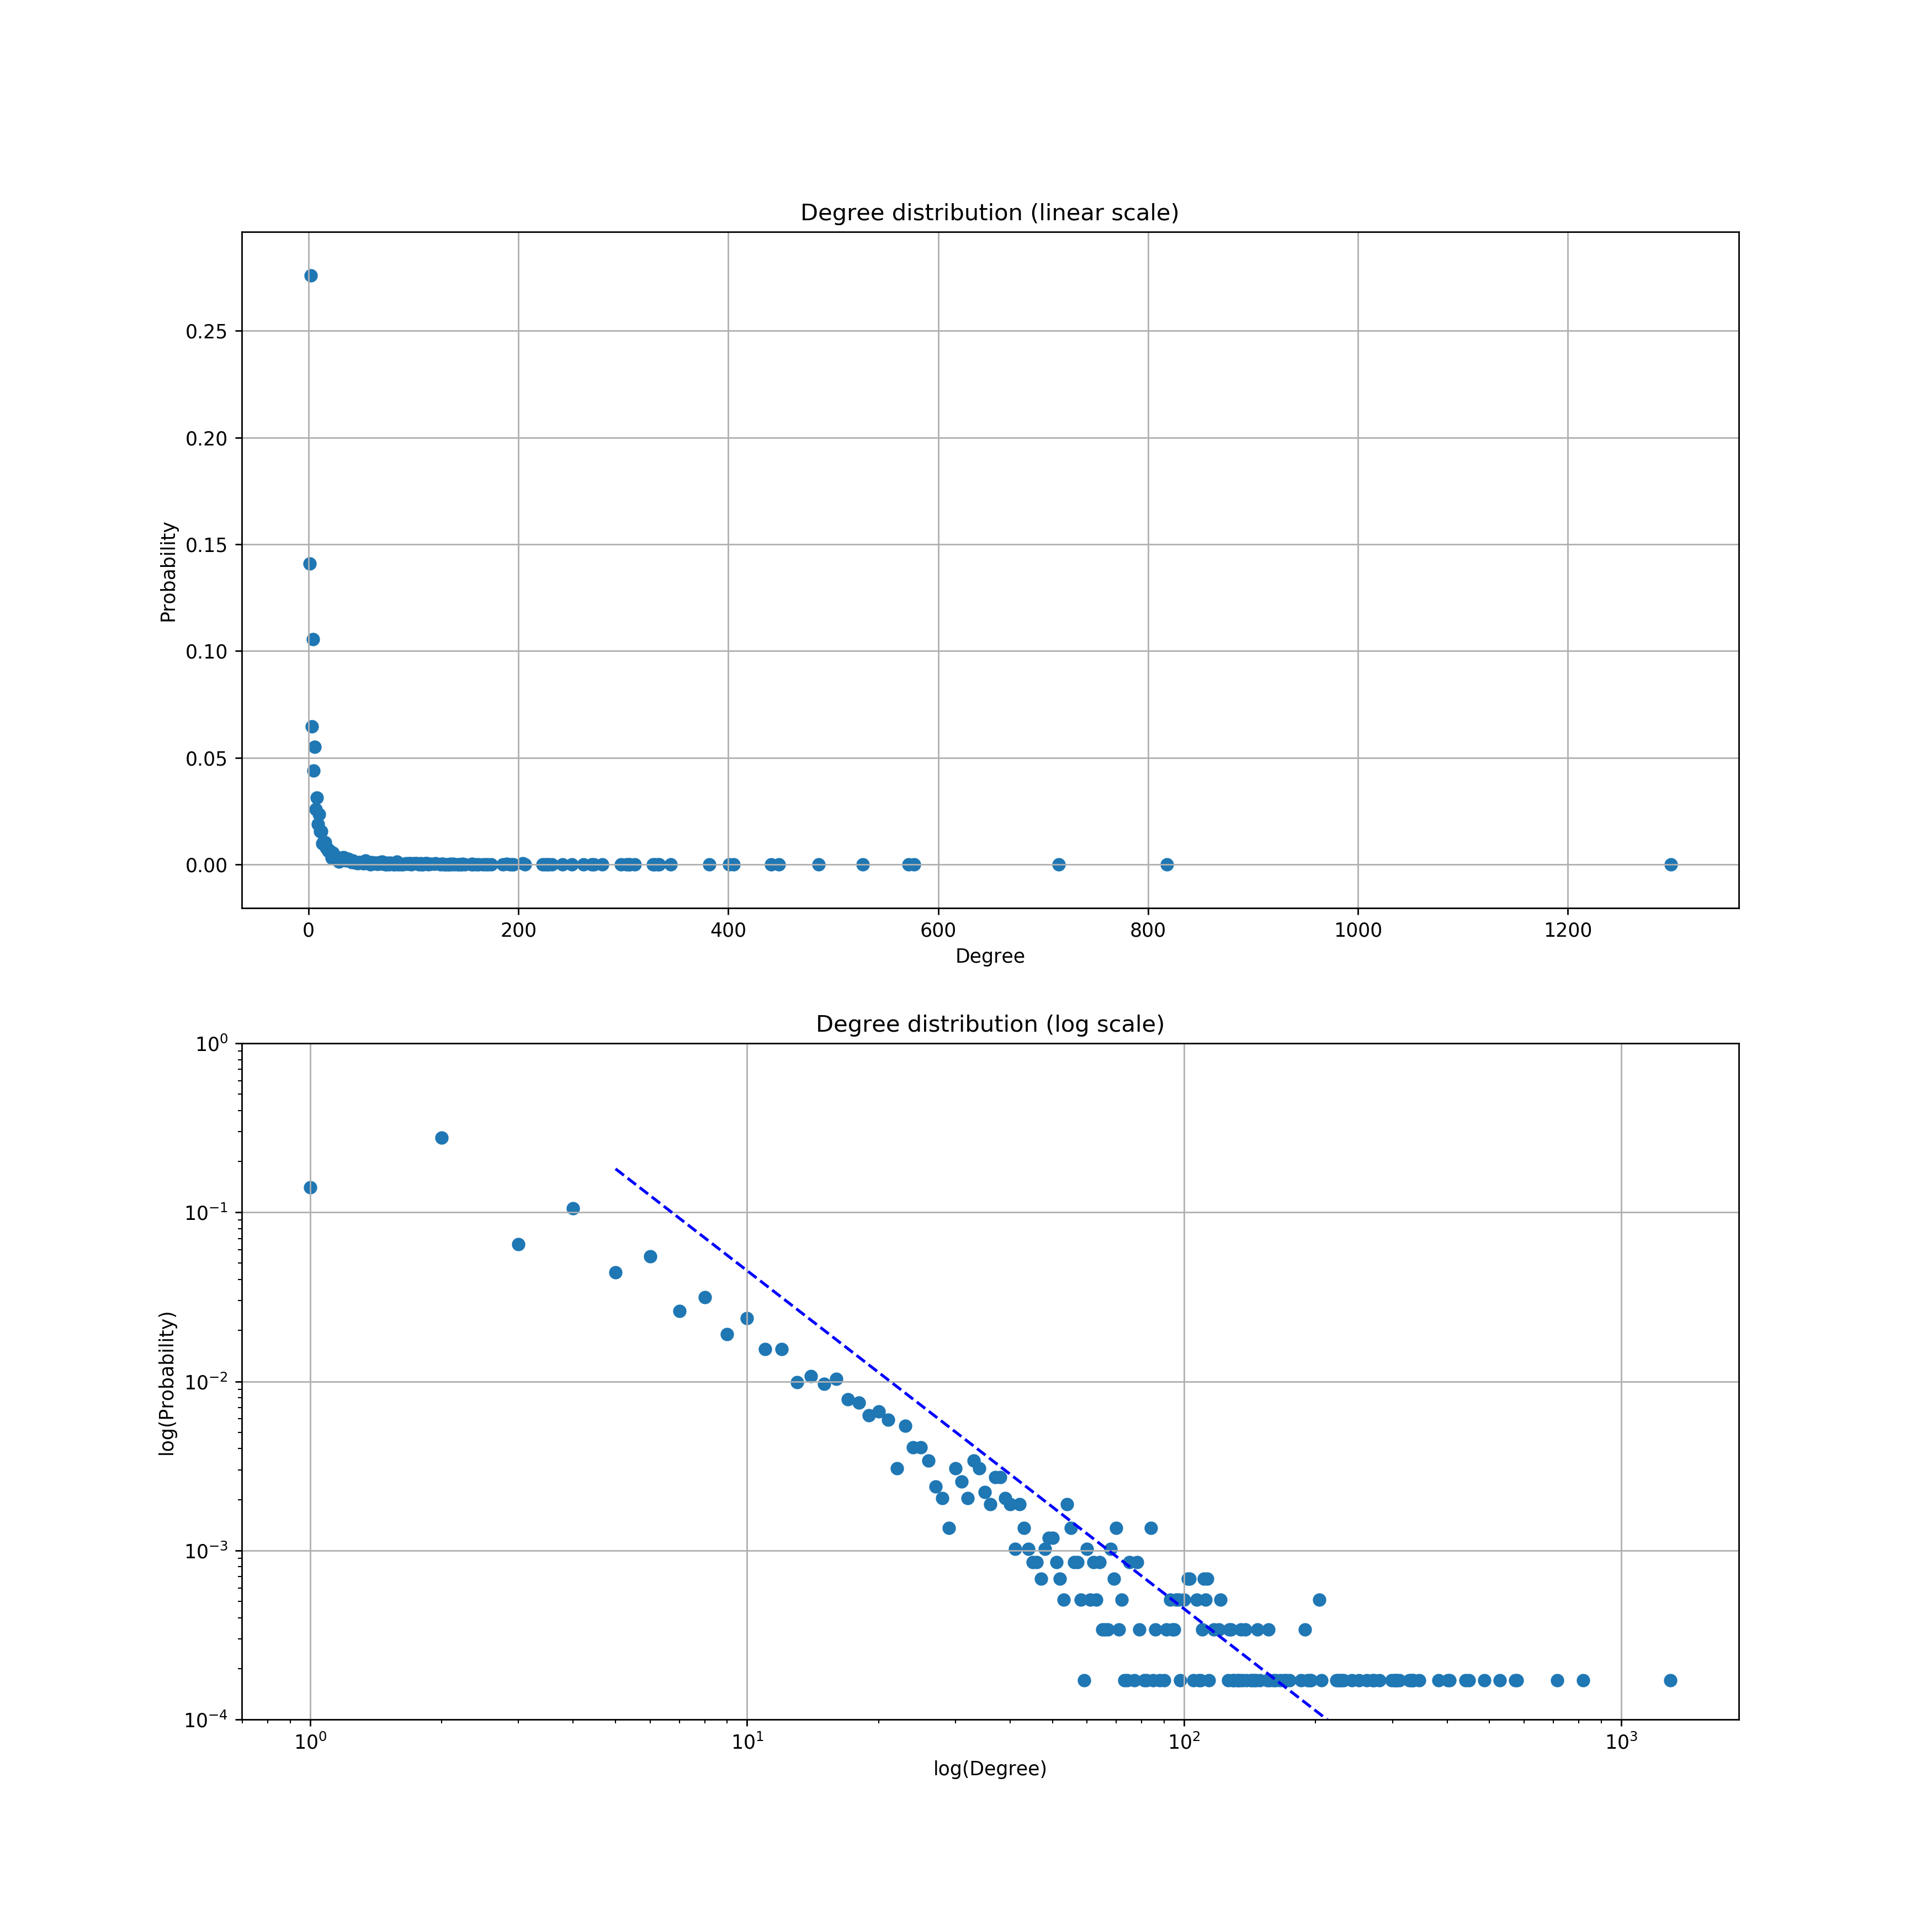

Calculating best minimal value for power law fit
c:\users\hp\.virtualenvs\network_science-3ktgw-v0\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha=  2.000700901043796


In [100]:
fig = plt.figure()
fig.set_size_inches(14.0, 14.0)

# Linear scale.
ax = plt.subplot(2, 1, 1)

plt.scatter(counts['Degree'], counts['Probability'])

plt.title('Degree distribution (linear scale)')
plt.xlabel('Degree')
plt.ylabel('Probability')

plt.grid()

# Log scale.
ax = plt.subplot(2, 1, 2)

plt.scatter(counts['Degree'], counts['Probability'])

plt.title('Degree distribution (log scale)')
plt.xlabel('log(Degree)')
plt.ylabel('log(Probability)')

ax.set_xscale('log')
ax.set_ylim(ymin=0.0001)

# This is the only way I found to make it work.
# Matplotlib log scale only works for positive values.
# Can't make symlog scale to work either.
ax.set_yscale('log')
ticks = [1,1e-01, 1e-02, 1e-03, 1e-04]
ax.set_yticks(ticks)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yticklabels([str(t) for t in ticks])
plt.grid()
#fit.plot_pdf( color= 'b', ax = ax)
data = np.array(stats['Degree']) # data can be list or numpy array


#part responsible for power law
fit = powerlaw.Fit(np.array(stats['Degree'])+1, discrete=True)
# OR WE CAN DEFINE XMIN PARAMETER TO ADJUST BETTER POWER LAW 
#The data value beyond which distributions should be fitted. If None an optimal one will be calculated.
#fit = powerlaw.Fit(np.array(stats['Degree'])+1, xmin=1.7, discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
#fit.plot_pdf( color= 'r')

fig.savefig("output/degree_distribution.pdf")

plt.show()

print('alpha= ',fit.power_law.alpha)

### 3.2) In-Degree centrality

#### Top 10 nodes with highest in-degree centrality

In [101]:
stats.sort_values(by='InDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree
23,35,1298.0,535.0,763.0
2571,2642,818.0,412.0,406.0
1785,1810,715.0,311.0,404.0
1980,2028,572.0,279.0,293.0
945,905,528.0,264.0,264.0
3,1,441.0,226.0,215.0
4071,4172,486.0,222.0,264.0
10,7,448.0,216.0,232.0
4089,4197,405.0,203.0,202.0
7,13,401.0,191.0,210.0


#### InDegree distribution

In [102]:
counts = stats.groupby(['InDegree']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts.head(10)

,InDegree,Frequency,Probability
0,0.0,23,0.003911
1,1.0,2427,0.412685
2,2.0,1042,0.177181
3,3.0,565,0.096072
4,4.0,335,0.056963
5,5.0,235,0.039959
6,6.0,189,0.032137
7,7.0,142,0.024146
8,8.0,95,0.016154
9,9.0,87,0.014793


<IPython.core.display.Javascript object>


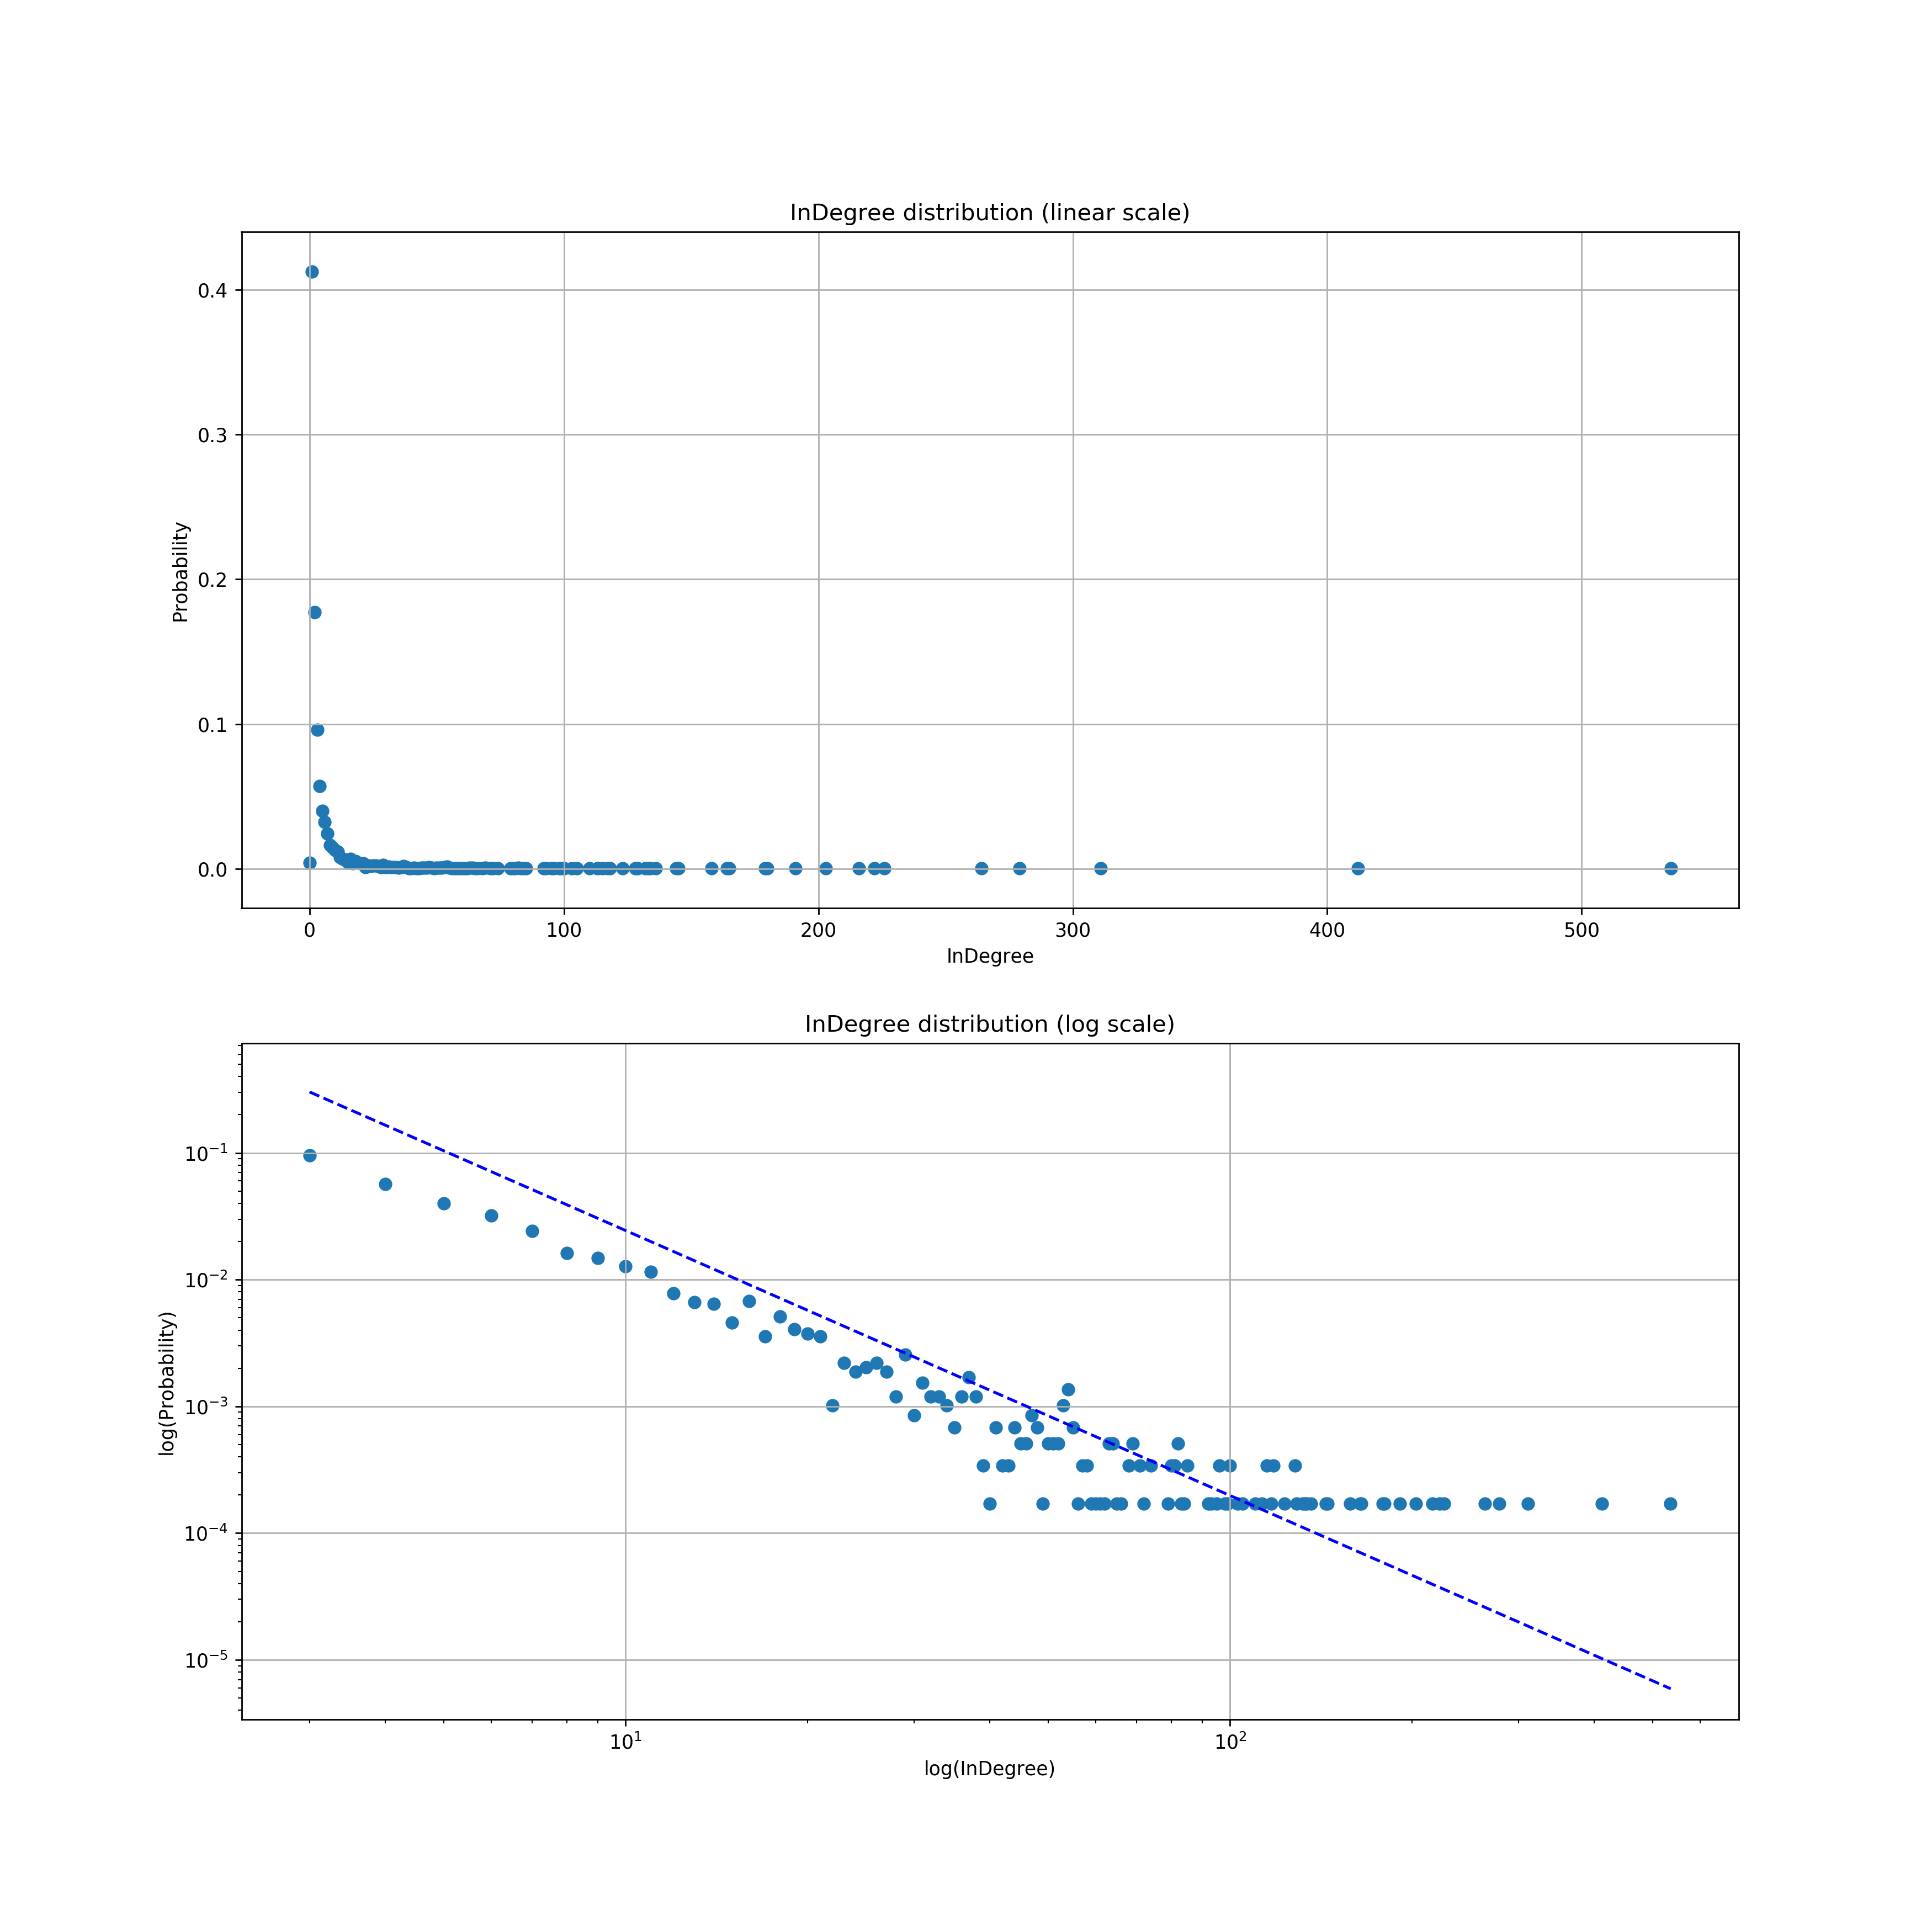

Calculating best minimal value for power law fit
c:\users\hp\.virtualenvs\network_science-3ktgw-v0\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
c:\users\hp\.virtualenvs\network_science-3ktgw-v0\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha=  2.0906882890864873


In [103]:
fig = plt.figure()
fig.set_size_inches(14.0, 14.0)

# Linear scale.
ax = plt.subplot(2, 1, 1)

plt.scatter(counts['InDegree'], counts['Probability'])

plt.title('InDegree distribution (linear scale)')
plt.xlabel('InDegree')
plt.ylabel('Probability')

plt.grid()

# Log scale.
ax = plt.subplot(2, 1, 2)

plt.scatter(counts['InDegree'], counts['Probability'])

plt.title('InDegree distribution (log scale)')
plt.xlabel('log(InDegree)')
plt.ylabel('log(Probability)')

ax.set_xscale('log')

# This is the only way I found to make it work.
# Matplotlib log scale only works for positive values.
# Can't make symlog scale to work either.
ax.set_yscale('log')
ticks = [1, 1e-01 ,1e-02, 1e-03, 1e-04]
ax.set_yticks(ticks)
xticks = [1, 1e+01, 1e+02, 1e+03, 1e+04]
ax.set_xticks(xticks)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yticklabels([str(t) for t in ticks])
plt.grid()


fit = powerlaw.Fit(np.array(stats['InDegree'])+1, discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
#fit.plot_pdf( color= 'r')

fig.savefig("output/in_degree_distribution.pdf")

plt.show()

print('alpha= ',fit.power_law.alpha)


### 3.3) Out-Degree centrality

#### Top 10 nodes with highest out-degree centrality

In [104]:
stats.sort_values(by='OutDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree
23,35,1298.0,535.0,763.0
2571,2642,818.0,412.0,406.0
1785,1810,715.0,311.0,404.0
2071,2125,577.0,180.0,397.0
1980,2028,572.0,279.0,293.0
945,905,528.0,264.0,264.0
4071,4172,486.0,222.0,264.0
10,7,448.0,216.0,232.0
3,1,441.0,226.0,215.0
3032,3129,229.0,17.0,212.0


#### OutDegree Distribution

In [105]:
counts = stats.groupby(['OutDegree']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts.head(10)

,OutDegree,Frequency,Probability
0,0.0,1067,0.181432
1,1.0,1793,0.304880
2,2.0,821,0.139602
3,3.0,479,0.081449
4,4.0,311,0.052882
5,5.0,235,0.039959
6,6.0,147,0.024996
7,7.0,116,0.019725
8,8.0,120,0.020405
9,9.0,77,0.013093


<IPython.core.display.Javascript object>


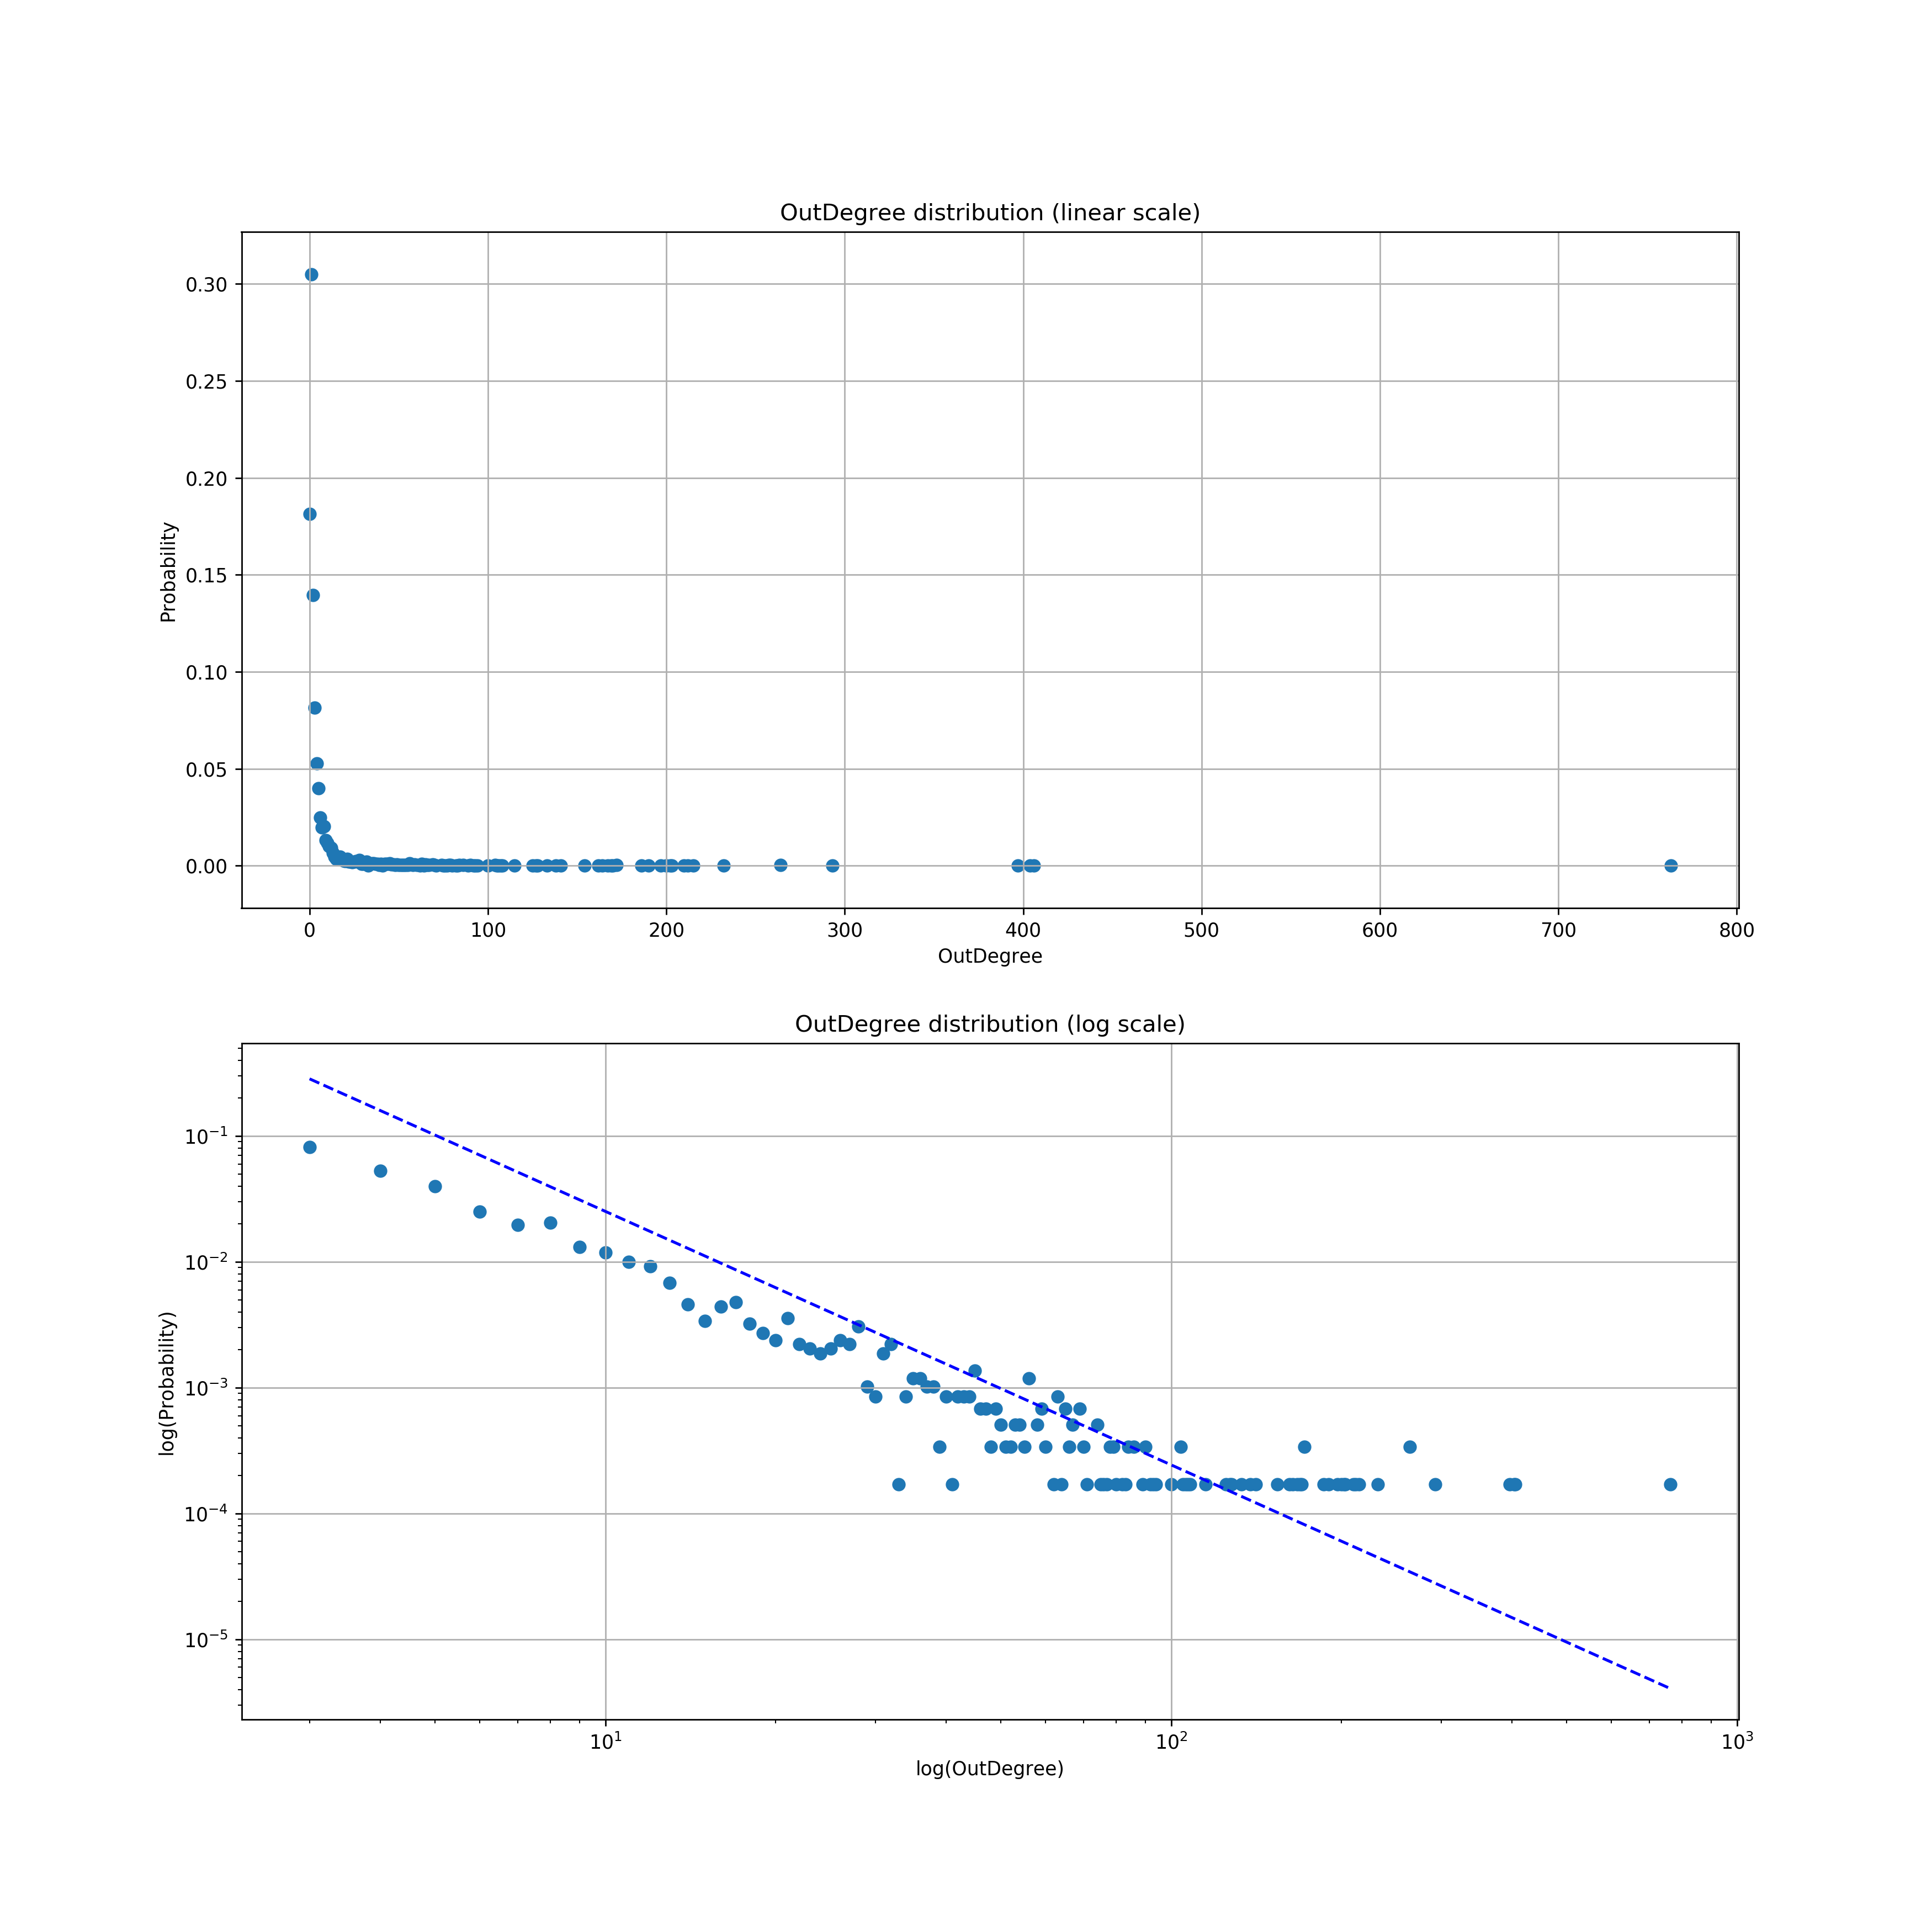

Calculating best minimal value for power law fit
c:\users\hp\.virtualenvs\network_science-3ktgw-v0\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
c:\users\hp\.virtualenvs\network_science-3ktgw-v0\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha=  2.014455707503751


In [106]:
fig = plt.figure()
fig.set_size_inches(14.0, 14.0)

# Linear scale.
ax = plt.subplot(2, 1, 1)

plt.scatter(counts['OutDegree'], counts['Probability'])

plt.title('OutDegree distribution (linear scale)')
plt.xlabel('OutDegree')
plt.ylabel('Probability')

plt.grid()

# Log scale.
ax = plt.subplot(2, 1, 2)

plt.scatter(counts['OutDegree'], counts['Probability'])

plt.title('OutDegree distribution (log scale)')
plt.xlabel('log(OutDegree)')
plt.ylabel('log(Probability)')

ax.set_xscale('log')

# This is the only way I found to make it work.
# Matplotlib log scale only works for positive values.
# Can't make symlog scale to work either.
ax.set_yscale('log')
ticks = [1, 1e-01 ,1e-02, 1e-03, 1e-04]
ax.set_yticks(ticks)
xticks = [1, 1e+01, 1e+02, 1e+03, 1e+04]
ax.set_xticks(xticks)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yticklabels([str(t) for t in ticks])
plt.grid()

fit = powerlaw.Fit(np.array(stats['OutDegree'])+1, discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
#fit.plot_pdf( color= 'r')


fig.savefig("output/out_degree_distribution.pdf")

plt.show()


print('alpha= ',fit.power_law.alpha)


## 4) Weighted degree centrality

In [107]:
# convert dictionary into list of tuples
weighted_degree_list = [v for k, v in graph.degree(weight='Rating')] 
weighted_in_degree_list = [v for k, v in graph.in_degree(weight='Rating')] 
weighted_out_degree_list = [v for k, v in graph.out_degree(weight='Rating')] 

# Store node degree centrality (considering graph as unirected)
stats['WeightedDegree'] = weighted_degree_list

# Store node in-degree centrality (considering graph as directed)
stats['WeightedInDegree'] = weighted_in_degree_list

# Store node out-degree centrality (considering graph as directed)
stats['WeightedOutDegree'] = weighted_out_degree_list

### 4.1) Weighted degree centrality (considering graph as undirected)

#### Top 10 nodes with highest weighted degree centrality

In [108]:
stats.sort_values(by='WeightedDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
23,35,1298.0,535.0,763.0,1890,1016,874
2571,2642,818.0,412.0,406.0,1805,1041,764
3,1,441.0,226.0,215.0,1234,801,433
10,7,448.0,216.0,232.0,1125,614,511
967,1018,382.0,179.0,203.0,775,471,304
4169,4291,330.0,158.0,172.0,697,360,337
4089,4197,405.0,203.0,202.0,677,416,261
7,13,401.0,191.0,210.0,627,341,286
1980,2028,572.0,279.0,293.0,578,202,376
1350,1396,280.0,118.0,162.0,518,237,281


#### Top 10 nodes with lowest weighted degree centrality

In [109]:
stats.sort_values(by='WeightedDegree').head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
1785,1810,715.0,311.0,404.0,-706,230,-936
3647,3744,113.0,81.0,32.0,-595,-675,80
2071,2125,577.0,180.0,397.0,-560,439,-999
2206,2266,194.0,53.0,141.0,-508,26,-534
2692,2691,45.0,4.0,41.0,-373,4,-377
3689,3789,35.0,6.0,29.0,-350,-60,-290
2349,2351,48.0,4.0,44.0,-342,6,-348
3690,3790,34.0,6.0,28.0,-340,-60,-280
3693,3791,34.0,6.0,28.0,-340,-60,-280
3686,3786,34.0,6.0,28.0,-340,-60,-280


#### Weighted degree distribution

In [110]:
counts = stats.groupby(['WeightedDegree']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts.head(10)

,WeightedDegree,Frequency,Probability
0,-706,1,0.00017
1,-595,1,0.00017
2,-560,1,0.00017
3,-508,1,0.00017
4,-373,1,0.00017
5,-350,1,0.00017
6,-342,1,0.00017
7,-340,4,0.00068
8,-335,1,0.00017
9,-330,3,0.00051


<IPython.core.display.Javascript object>


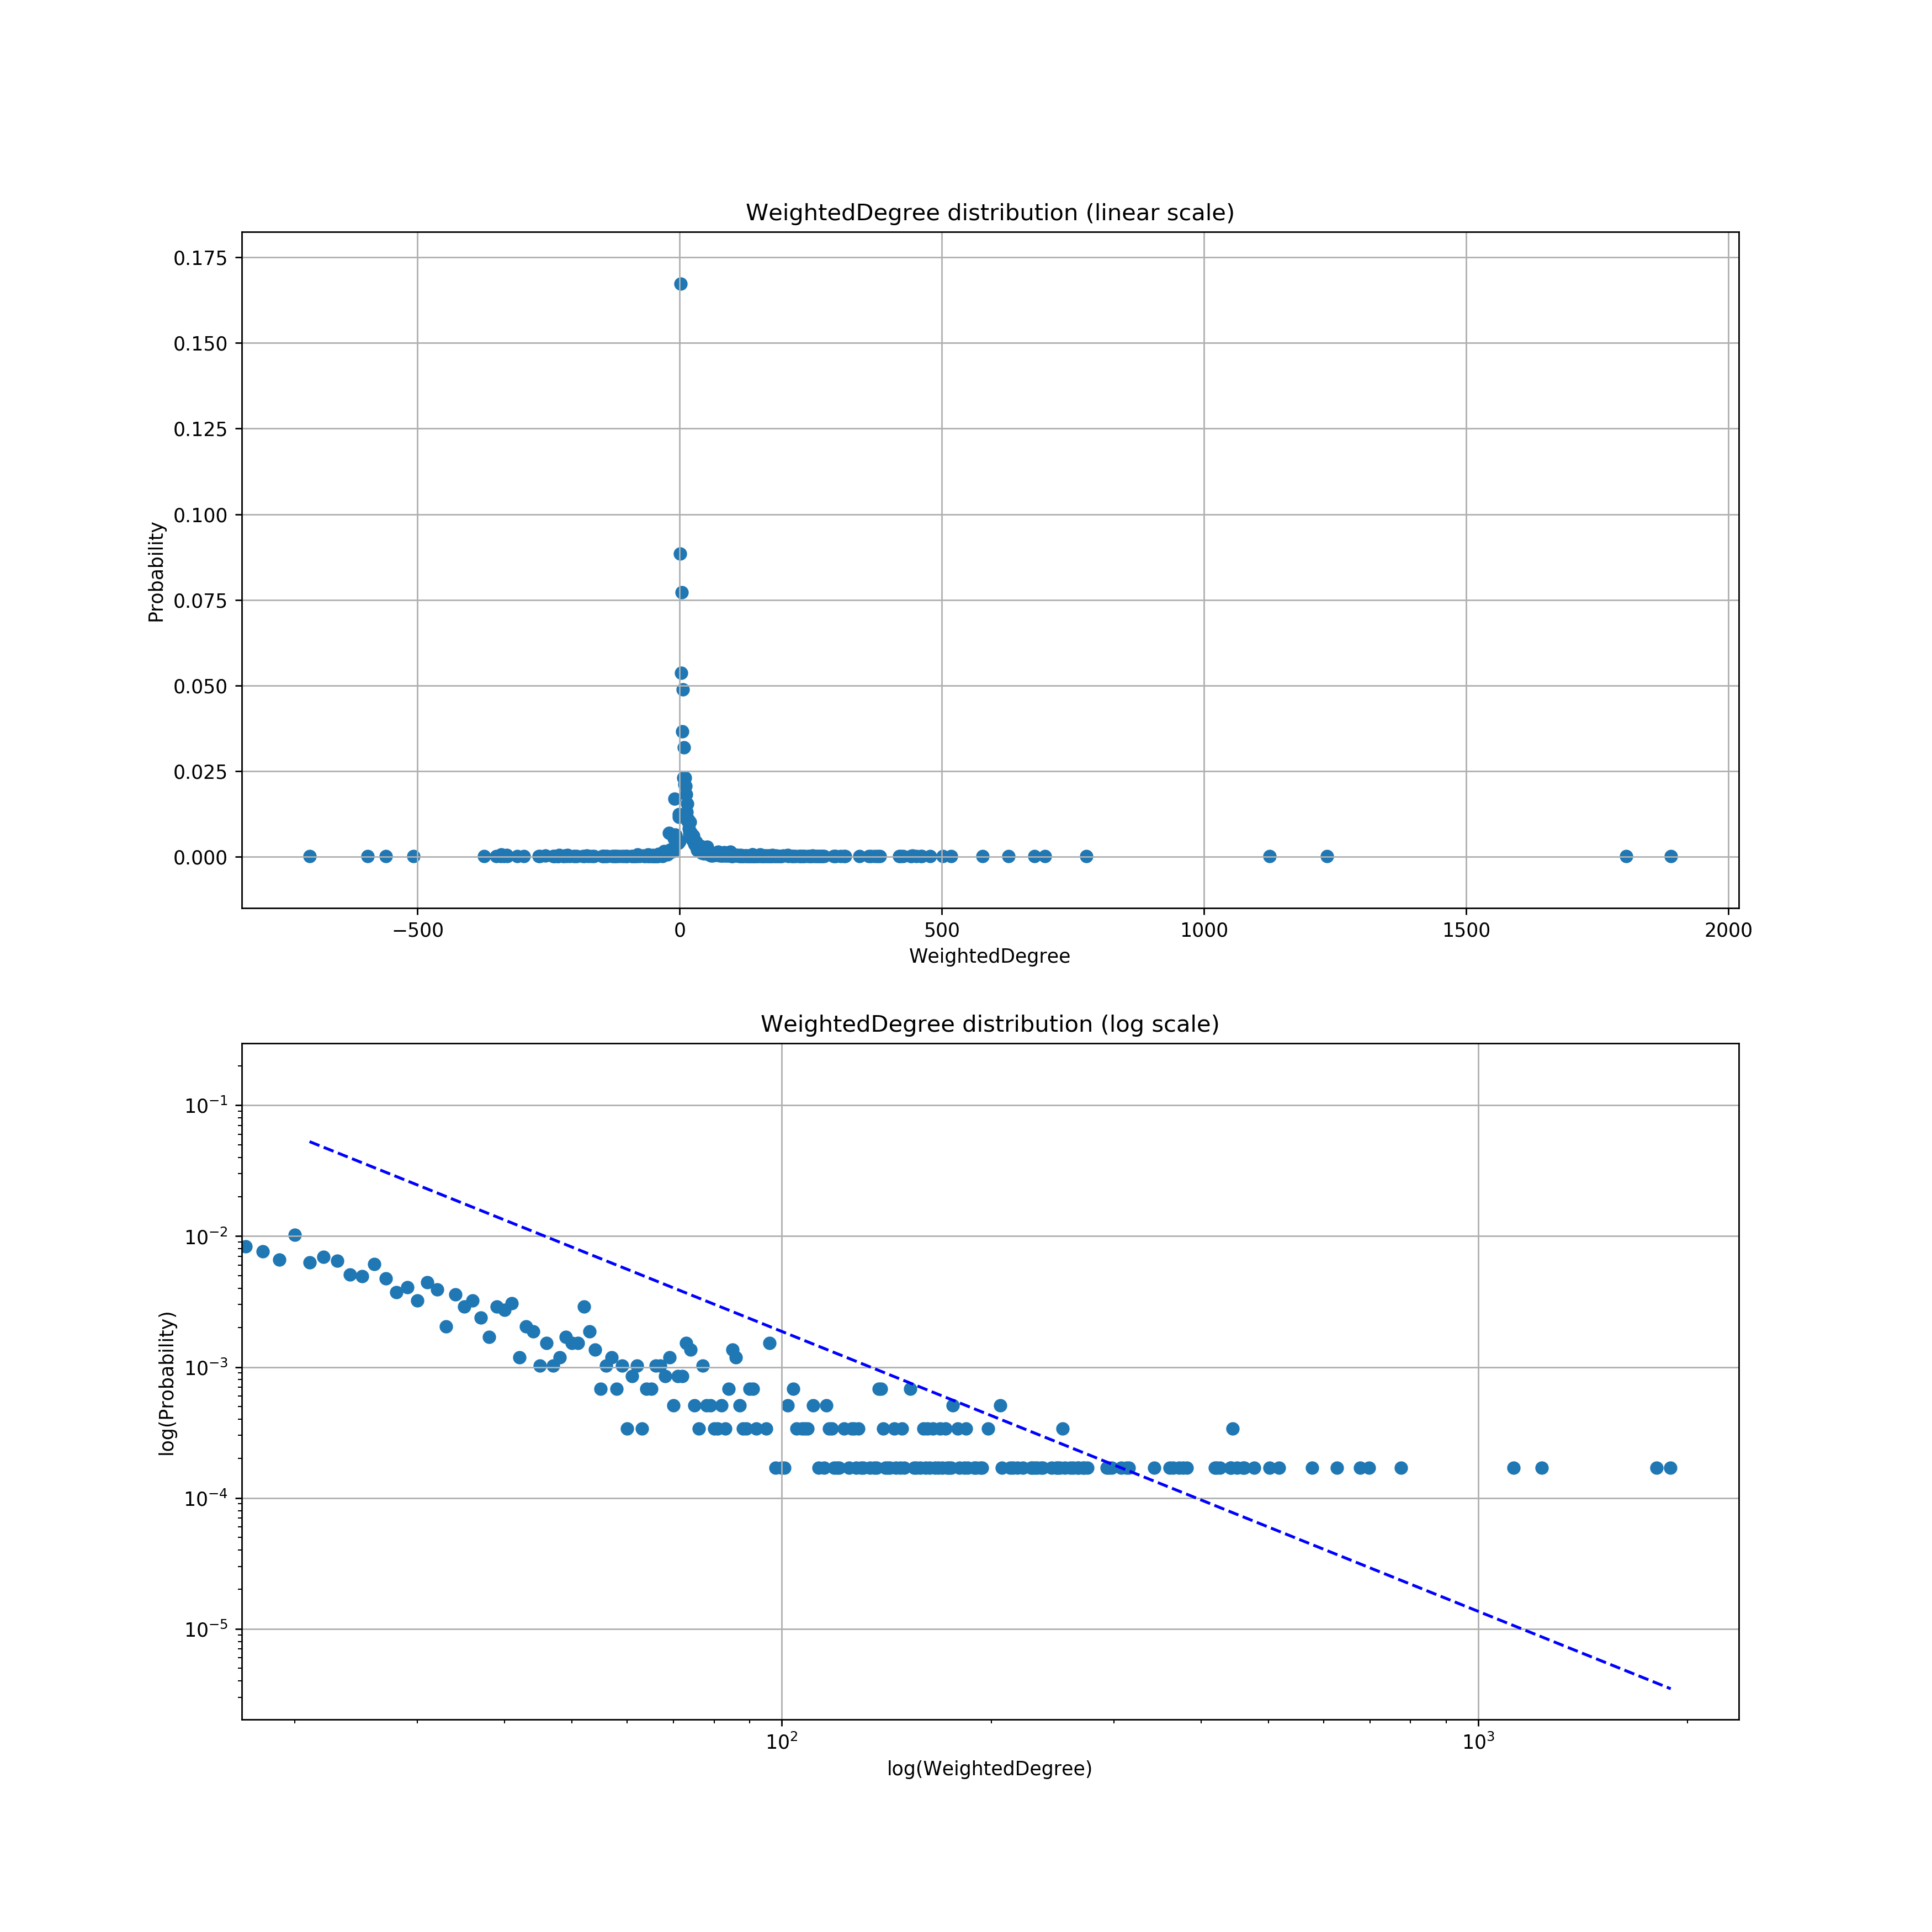

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
c:\users\hp\.virtualenvs\network_science-3ktgw-v0\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
c:\users\hp\.virtualenvs\network_science-3ktgw-v0\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha=  2.1391550275873072


In [111]:
fig = plt.figure()
fig.set_size_inches(14.0, 14.0)

# Linear scale.
ax = plt.subplot(2, 1, 1)

plt.scatter(counts['WeightedDegree'], counts['Probability'])

plt.title('WeightedDegree distribution (linear scale)')
plt.xlabel('WeightedDegree')
plt.ylabel('Probability')

plt.grid()

# Log scale.
ax = plt.subplot(2, 1, 2)

plt.scatter(counts['WeightedDegree'], counts['Probability'])

plt.title('WeightedDegree distribution (log scale)')
plt.xlabel('log(WeightedDegree)')
plt.ylabel('log(Probability)')

ax.set_xscale('log')

# This is the only way I found to make it work.
# Matplotlib log scale only works for positive values.
# Can't make symlog scale to work either.
ax.set_yscale('log')
ticks = [1, 1e-01 ,1e-02, 1e-03, 1e-04]
ax.set_yticks(ticks)
xticks = [1, 1e+01, 1e+02, 1e+03, 1e+04]
ax.set_xticks(xticks)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yticklabels([str(t) for t in ticks])
plt.grid()

fit = powerlaw.Fit(np.array(stats['WeightedDegree'])+1, discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
#fit.plot_pdf( color= 'r')


fig.savefig("output/weighted_degree_distribution.pdf")

plt.show()

print('alpha= ',fit.power_law.alpha)

### 4.2) Weighted In-Degree centrality

#### Top 10 nodes with highest weighted in-degree centrality

In [23]:
stats.sort_values(by='WeightedInDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
2587,2642,818.0,412.0,406.0,1805,1041,764
26,35,1298.0,535.0,763.0,1890,1016,874
0,1,441.0,226.0,215.0,1234,801,433
6,7,448.0,216.0,232.0,1125,614,511
4092,4172,486.0,222.0,264.0,255,472,-217
977,1018,382.0,179.0,203.0,775,471,304
2077,2125,577.0,180.0,397.0,-560,439,-999
4115,4197,405.0,203.0,202.0,677,416,261
4206,4291,330.0,158.0,172.0,697,360,337
10,13,401.0,191.0,210.0,627,341,286


#### Top 10 nodes with lowest weighted in-degree centrality

In [24]:
stats.sort_values(by='WeightedInDegree').head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
3668,3744,113.0,81.0,32.0,-595,-675,80
2446,2498,45.0,45.0,0.0,-256,-256,0
1341,1383,162.0,96.0,66.0,-46,-232,186
4443,4531,47.0,25.0,22.0,-238,-230,-8
1970,2017,54.0,45.0,9.0,-214,-229,15
4564,4654,46.0,25.0,21.0,-233,-186,-47
4654,4744,21.0,19.0,2.0,-199,-179,-20
4591,4681,39.0,22.0,17.0,-223,-176,-47
4582,4672,30.0,18.0,12.0,-256,-169,-87
4596,4686,38.0,25.0,13.0,-242,-167,-75


#### Weighted In-Degree distribution

In [25]:
counts = stats.groupby(['WeightedInDegree']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts.head(10)

,WeightedInDegree,Frequency,Probability
0,-675,1,0.00017
1,-256,1,0.00017
2,-232,1,0.00017
3,-230,1,0.00017
4,-229,1,0.00017
5,-186,1,0.00017
6,-179,1,0.00017
7,-176,1,0.00017
8,-169,1,0.00017
9,-167,1,0.00017


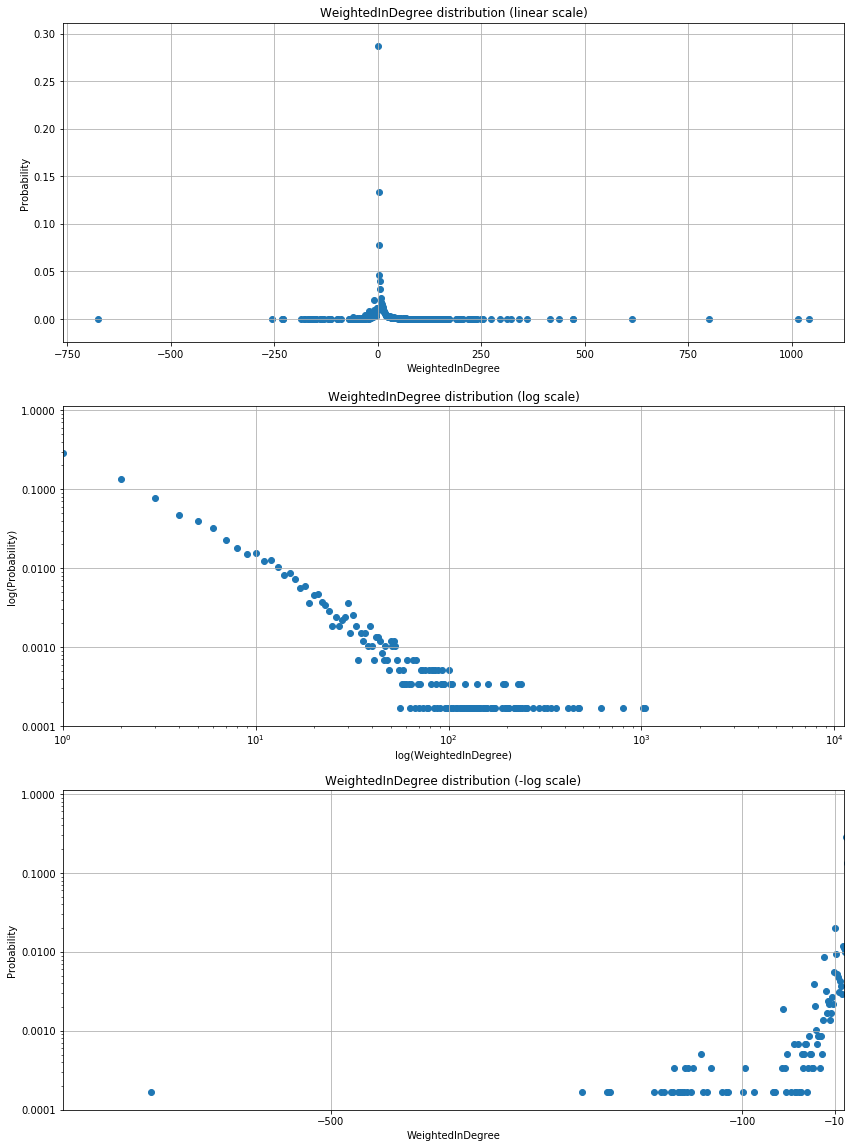

In [26]:
fig = plt.figure()
fig.set_size_inches(14.0, 20.0)

# Linear scale.
ax = plt.subplot(3, 1, 1)

plt.scatter(counts['WeightedInDegree'], counts['Probability'])

plt.title('WeightedInDegree distribution (linear scale)')
plt.xlabel('WeightedInDegree')
plt.ylabel('Probability')

plt.grid()

# Log scale.
ax = plt.subplot(3, 1, 2)

plt.scatter(counts['WeightedInDegree'], counts['Probability'])

plt.title('WeightedInDegree distribution (log scale)')
plt.xlabel('log(WeightedInDegree)')
plt.ylabel('log(Probability)')

ax.set_xscale('log')

# This is the only way I found to make it work.
# Matplotlib log scale only works for positive values.
# Can't make symlog scale to work either.
ax.set_yscale('log')
ticks = [1,1e-01, 1e-02, 1e-03, 1e-04]
ax.set_yticks(ticks)
xticks = [1, 1e+01, 1e+02, 1e+03, 1e+04]
ax.set_xticks(xticks)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yticklabels([str(t) for t in ticks])
plt.grid()

ax = plt.subplot(3, 1, 3)
plt.scatter(counts['WeightedInDegree'], counts['Probability'])

plt.title('WeightedInDegree distribution (-log scale)')
plt.xlabel('WeightedInDegree')
plt.ylabel('Probability')

ax.set_yscale('log')

ticks = [1,1e-01, 1e-02, 1e-03, 1e-04]
ax.set_yticks(ticks)
xticks = [-500, -1e+02, -1e+01]
ax.set_xticks(xticks)
ax.set_xlim(left=None, right=-1)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yticklabels([str(t) for t in ticks])
plt.grid()


fig.savefig("output/weighted_in_degree_distribution.pdf")

plt.show()

### 4.3) Weighted Out-Degree centrality

#### Top 10 nodes with highest weighted out-degree centrality

In [27]:
stats.sort_values(by='WeightedOutDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
26,35,1298.0,535.0,763.0,1890,1016,874
2587,2642,818.0,412.0,406.0,1805,1041,764
6,7,448.0,216.0,232.0,1125,614,511
0,1,441.0,226.0,215.0,1234,801,433
217,257,111.0,18.0,93.0,477,57,420
1981,2028,572.0,279.0,293.0,578,202,376
4206,4291,330.0,158.0,172.0,697,360,337
977,1018,382.0,179.0,203.0,775,471,304
10,13,401.0,191.0,210.0,627,341,286
1354,1396,280.0,118.0,162.0,518,237,281


#### Top 10 nodes with lowest weighted out-degree centrality

In [28]:
stats.sort_values(by='WeightedOutDegree').head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
2077,2125,577.0,180.0,397.0,-560,439,-999
1764,1810,715.0,311.0,404.0,-706,230,-936
2218,2266,194.0,53.0,141.0,-508,26,-534
2020,2067,303.0,117.0,186.0,-267,197,-464
2635,2691,45.0,4.0,41.0,-373,4,-377
2302,2351,48.0,4.0,44.0,-342,6,-348
2876,2934,126.0,48.0,78.0,-174,128,-302
4372,4458,49.0,9.0,40.0,-335,-35,-300
3713,3789,35.0,6.0,29.0,-350,-60,-290
3714,3790,34.0,6.0,28.0,-340,-60,-280


#### Weighted Out-Degree distribution

In [29]:
counts = stats.groupby(['WeightedOutDegree']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts.head(10)

,WeightedOutDegree,Frequency,Probability
0,-999,1,0.00017
1,-936,1,0.00017
2,-534,1,0.00017
3,-464,1,0.00017
4,-377,1,0.00017
5,-348,1,0.00017
6,-302,1,0.00017
7,-300,1,0.00017
8,-290,1,0.00017
9,-280,6,0.00102


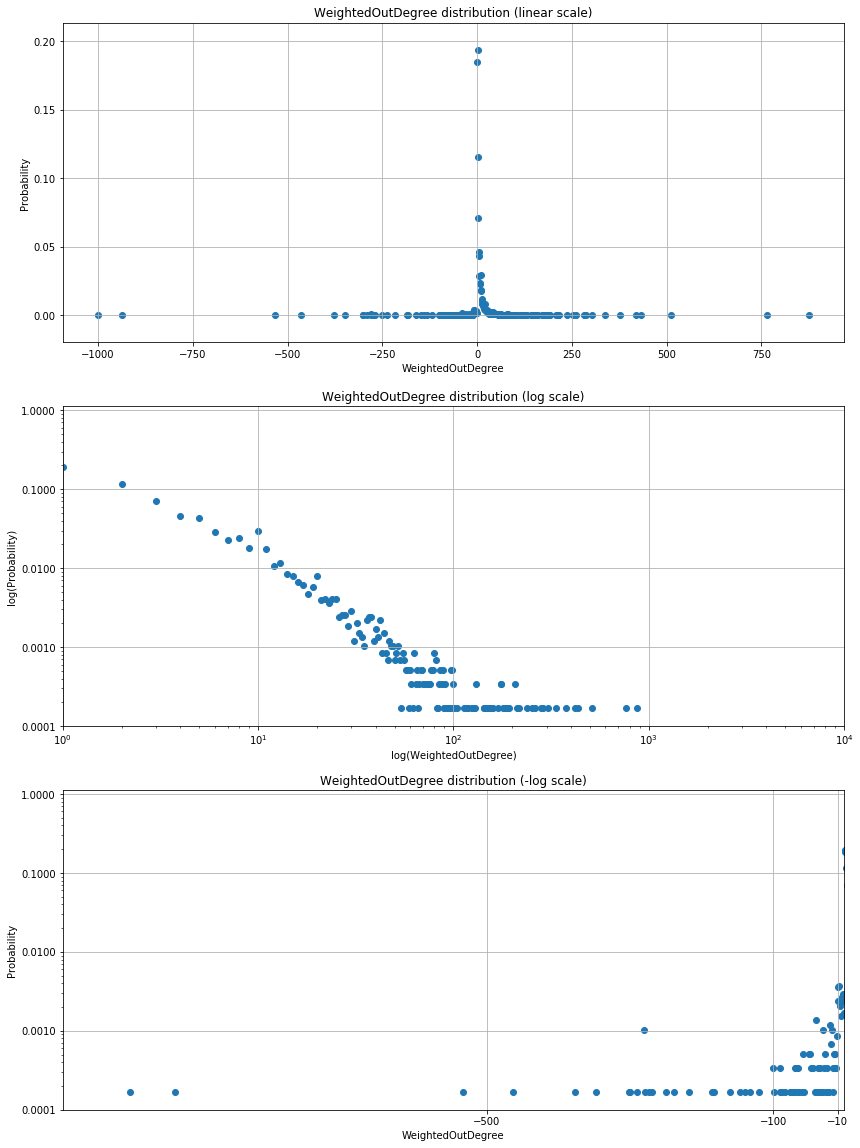

In [30]:
fig = plt.figure()
fig.set_size_inches(14.0, 20.0)

# Linear scale.
ax = plt.subplot(3, 1, 1)

plt.scatter(counts['WeightedOutDegree'], counts['Probability'])

plt.title('WeightedOutDegree distribution (linear scale)')
plt.xlabel('WeightedOutDegree')
plt.ylabel('Probability')

plt.grid()

# Log scale.
ax = plt.subplot(3, 1, 2)

plt.scatter(counts['WeightedOutDegree'], counts['Probability'])

plt.title('WeightedOutDegree distribution (log scale)')
plt.xlabel('log(WeightedOutDegree)')
plt.ylabel('log(Probability)')

ax.set_xscale('log')

# This is the only way I found to make it work.
# Matplotlib log scale only works for positive values.
# Can't make symlog scale to work either.
ax.set_yscale('log')
ticks = [1,1e-01, 1e-02, 1e-03, 1e-04]
ax.set_yticks(ticks)
xticks = [1, 1e+01, 1e+02, 1e+03, 1e+04]
ax.set_xticks(xticks)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yticklabels([str(t) for t in ticks])
plt.grid()

ax = plt.subplot(3, 1, 3)
plt.scatter(counts['WeightedOutDegree'], counts['Probability'])

plt.title('WeightedOutDegree distribution (-log scale)')
plt.xlabel('WeightedOutDegree')
plt.ylabel('Probability')

ax.set_yscale('log')

ticks = [1,1e-01, 1e-02, 1e-03, 1e-04]
ax.set_yticks(ticks)
xticks = [-500, -1e+02, -1e+01]
ax.set_xticks(xticks)
ax.set_xlim(left=None, right=-1)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yticklabels([str(t) for t in ticks])
plt.grid()


fig.savefig("output/weighted_out_degree_distribution.pdf")

plt.show()

## 5) Average node rating

In [31]:
# count weighted degree distribution
weighted_in_degree = dict()
weighted_out_degree = dict()
for instance in data.values:
    weighted_in_degree[instance[1]] = weighted_in_degree.get(instance[1], 0) + instance[2]
    weighted_in_degree[instance[0]] = weighted_in_degree.get(instance[0], 0)
    weighted_out_degree[instance[0]] = weighted_out_degree.get(instance[0], 0) + instance[2]
    weighted_out_degree[instance[1]] = weighted_out_degree.get(instance[1], 0)
        
in_degree_list_weight = list()

for key, value in weighted_in_degree.items():
    #third value is average value of ratings that node received from other nodes
    if graph.in_degree[key] != 0:
        in_degree_list_weight.append((int(key), value / graph.in_degree[key]))
    else:
        in_degree_list_weight.append((int(key), 0))

out_degree_list_weight = list()
for key, value in weighted_out_degree.items():
    #third value is average value of ratings that node gave to other nodes
    if graph.out_degree[key] != 0:
        out_degree_list_weight.append((int(key), value / graph.out_degree[key]))
    else:
        out_degree_list_weight.append((int(key), 0))

stats['inAvgRating'] = [round(v,2) for k, v in sorted(in_degree_list_weight, key=lambda tup: tup[0])]
stats['outAvgRating'] = [round(v,2) for k, v in sorted(out_degree_list_weight, key=lambda tup: tup[0])]

stats.head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree,inAvgRating,outAvgRating
0,1,441.0,226.0,215.0,1234,801,433,3.54,2.01
1,2,86.0,41.0,45.0,266,123,143,3.00,3.18
2,3,21.0,21.0,0.0,-6,-6,0,-0.29,0.00
3,4,117.0,54.0,63.0,343,168,175,3.11,2.78
4,5,6.0,3.0,3.0,14,7,7,2.33,2.33
5,6,84.0,44.0,40.0,158,61,97,1.39,2.42
6,7,448.0,216.0,232.0,1125,614,511,2.84,2.20
7,8,4.0,3.0,1.0,20,17,3,5.67,3.00
8,9,2.0,1.0,1.0,12,2,10,2.00,10.00
9,10,13.0,5.0,8.0,86,30,56,6.00,7.00


###  5.1) In & out average rating distributions

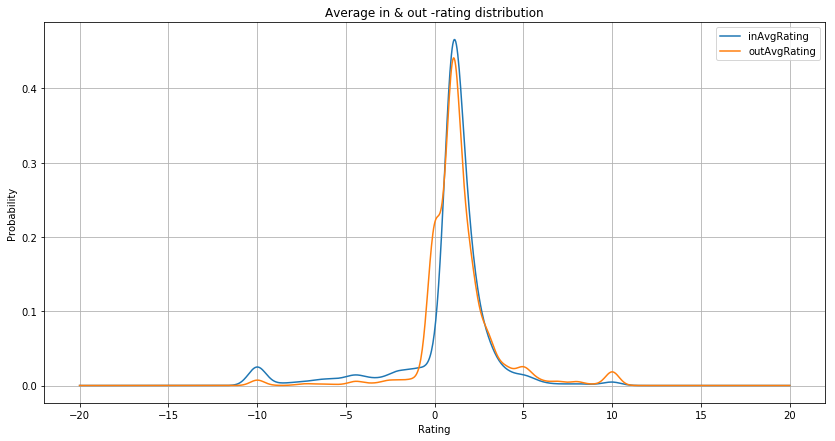

In [32]:
fig = plt.figure()
fig.set_size_inches(14.0, 7.0)

# Linear scale.
ax = plt.subplot(1, 1, 1)

# Plot the histogram.
stats['inAvgRating'].plot(kind='density', legend=True)
stats['outAvgRating'].plot(kind='density', legend=True)

plt.title('Average in & out -rating distribution')
plt.xlabel('Rating')
plt.ylabel('Probability')

plt.grid()

fig.savefig("output/avg_in_out_rating_distribution.pdf")

plt.show()

### 5.2) Absolute difference between in & out average ratings distribution

In [33]:
diff = np.abs(stats['inAvgRating'] - stats['outAvgRating'])
#diff.head(10)

In [34]:
diff.describe()

count    5881.000000
mean        1.509163
std         2.557575
min         0.000000
25%         0.000000
50%         0.500000
75%         1.500000
max        20.000000
dtype: float64

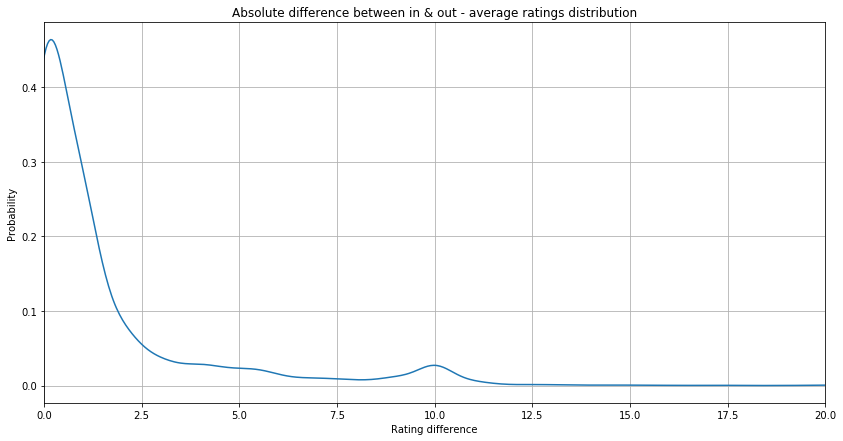

In [35]:
fig = plt.figure()
fig.set_size_inches(14.0, 7.0)

# Linear scale.
ax = plt.subplot(1, 1, 1)

# Plot the histogram.
diff.plot(kind='density')

plt.title('Absolute difference between in & out - average ratings distribution')
plt.xlabel('Rating difference')
plt.ylabel('Probability')

ax.set_xlim([0,20])

plt.grid()

fig.savefig("output/abs_diff_avg_in_out_rating_distribution.pdf")

plt.show()

### 5.3) In & out average ratings 2d plane projection

Observations:
* 1st quadrant: User rates others positively. Others rate user positively.
* 2nd quadrant: User rates others positively. Others rate user negatively. (!!!)
* 3rd quadrant: User rates others negatively. Others rate user negatively.
* 4th quadrant: User rates others negatively. Others rate user positively. (!!!)

See counts below!


(Compare with y=x line)

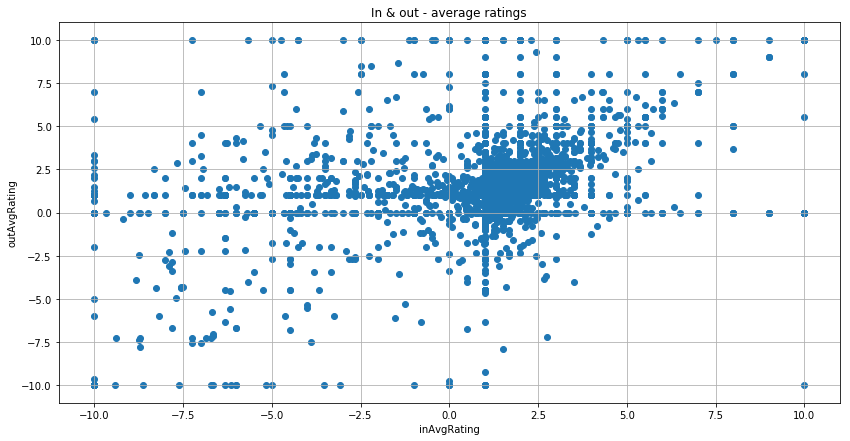

In [36]:
fig = plt.figure()
fig.set_size_inches(14.0, 7.0)

# Linear scale.
ax = plt.subplot(1, 1, 1)

plt.scatter(stats['inAvgRating'], stats['outAvgRating'])

plt.title('In & out - average ratings')
plt.xlabel('inAvgRating')
plt.ylabel('outAvgRating')

plt.grid()

fig.savefig("output/avg_in_out_rating_2d_projection.pdf")

plt.show()

In [37]:
zeroes = len(stats[(stats['inAvgRating'] == 0) & (stats['outAvgRating'] == 0)])
quad_1 = len(stats[(stats['inAvgRating'] >= 0) & (stats['outAvgRating'] >= 0)])
quad_2 = len(stats[(stats['inAvgRating'] < 0) & (stats['outAvgRating'] > 0)])
quad_3 = len(stats[(stats['inAvgRating'] <= 0) & (stats['outAvgRating'] <= 0)])
quad_4 = len(stats[(stats['inAvgRating'] > 0) & (stats['outAvgRating'] < 0)])

print("Quad 1: {0}".format(quad_1))
print("Quad 2: {0}".format(quad_2))
print("Quad 3: {0}".format(quad_3))
print("Quad 4: {0}".format(quad_4))
print("Total check: {0}".format(quad_1 + quad_2 + quad_3 + quad_4 -  zeroes))

Quad 1: 4916
Quad 2: 353
Quad 3: 476
Quad 4: 143
Total check: 5881


## 6) Stats summary

In [40]:
stats_description = stats.describe().drop('Node', axis=1)
stats_description

,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree,inAvgRating,outAvgRating
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,12.104064,6.052032,6.052032,12.249617,6.124809,6.124809,0.725761,1.345783
std,38.298915,17.675082,21.088387,66.453676,38.843600,38.521048,2.821867,2.208497
min,1.000000,0.000000,0.000000,-706.000000,-675.000000,-999.000000,-10.000000,-10.000000
25%,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.690000
50%,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,1.000000
75%,9.000000,5.000000,4.000000,12.000000,6.000000,7.000000,1.690000,2.000000
max,1298.000000,535.000000,763.000000,1890.000000,1041.000000,874.000000,10.000000,10.000000


#### Correlation analysis

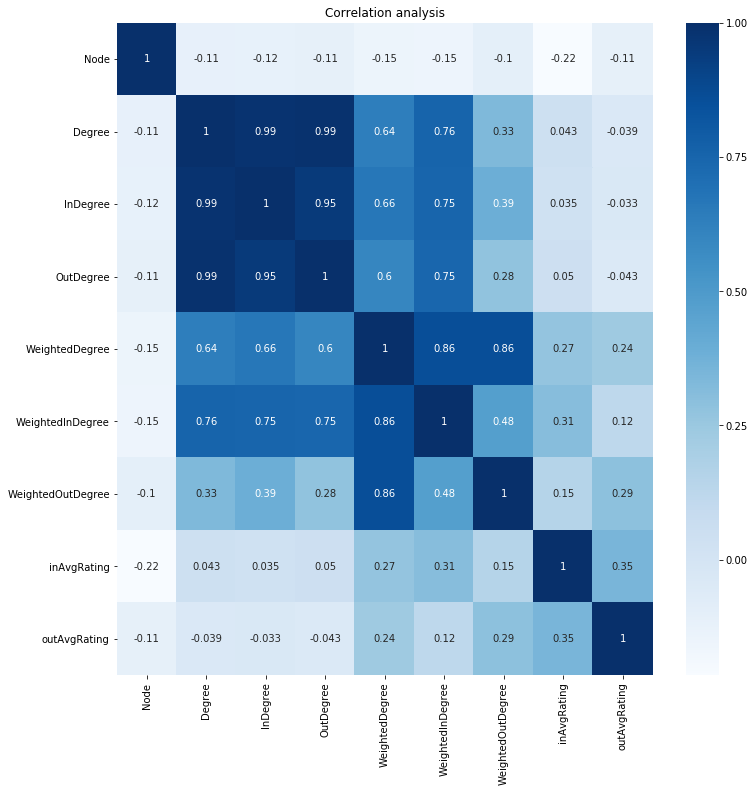

In [41]:
func.correlation_analysis(stats)